<a href="https://colab.research.google.com/github/JoshDTT/QGAN-2-cabezales/blob/main/qgangenv2%2C2cabezales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pennylane torch numpy matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93

In [ ]:
# ===============================
# 2. IMPORTACIONES
# ===============================
import numpy as np
import torch
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
from google.colab import files
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
# ===============================
# SUBIDA DEL ARCHIVO
# ===============================
uploaded = files.upload()

# ===============================
# CARGA Y PREPROCESAMIENTO
# ===============================


# Cargar el archivo
npz_filename = 'QIS_EXAM_200Events (1).npz'


# Cargar el archivo
data = np.load("QIS_EXAM_200Events (1).npz", allow_pickle=True)
train_dict = data['training_input'][()]
test_dict = data['test_input'][()]

# Combinar las clases en arrays y etiquetas
X_train = np.vstack([train_dict['0'], train_dict['1']])
y_train = np.hstack([
    np.zeros(len(train_dict['0'])),  # Fondo = 0
    np.ones(len(train_dict['1']))   # Señal = 1
])

X_test = np.vstack([test_dict['0'], test_dict['1']])
y_test = np.hstack([
    np.zeros(len(test_dict['0'])),
    np.ones(len(test_dict['1']))
])

# Confirmamos dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")




Saving QIS_EXAM_200Events (1).npz to QIS_EXAM_200Events (1).npz
X_train: (100, 5), y_train: (100,)
X_test: (100, 5), y_test: (100,)


In [ ]:
# ===========
# 1. Cargar y preparar datos
# ===========
data = np.load("QIS_EXAM_200Events (1).npz", allow_pickle=True)
train_dict = data['training_input'][()]
test_dict = data['test_input'][()]

X_train = np.vstack([train_dict['0'], train_dict['1']])
y_train = np.hstack([
    np.zeros(len(train_dict['0'])),  # Fondo
    np.ones(len(train_dict['1']))   # Señal
])
X_test = np.vstack([test_dict['0'], test_dict['1']])
y_test = np.hstack([
    np.zeros(len(test_dict['0'])),
    np.ones(len(test_dict['1']))
])

# Normalizar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# ===========
# Configuración del generador cuántico
# ===========
n_qubits = 5
layers = 3

dev = qml.device("default.qubit", wires=n_qubits)

def generator_circuit(params, z):
    # Codificar entrada z
    for i in range(n_qubits):
        qml.RZ(z[i], wires=i)
        qml.RY(z[i], wires=i)
        qml.RX(z[i], wires=i)


    # === Cuerpo del circuito ===
    param_idx = 0

    for _ in range(layers):
        # Rotaciones en cada qubit
        for i in range(n_qubits):
            qml.RX(params[param_idx], wires=i)
            qml.RY(params[param_idx + 1], wires=i)
            qml.RZ(params[param_idx + 2], wires=i)
            param_idx += 3

        # Entrelazamiento: vecinos
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])

        # Entrelazamiento: saltos de 2
        for i in range(n_qubits - 2):
            qml.CNOT(wires=[i, i+2])

        # CSWAPs en pares (control en el qubit 0)
        for i in range(1, n_qubits - 1, 2):
            qml.CSWAP(wires=[0, i, i + 1])

@qml.qnode(dev, interface="torch")
def quantum_generator(z, params):
    generator_circuit(params, z)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.params = nn.Parameter(0.01 * torch.randn(3 * n_qubits * layers))
        self.decode = nn.Sequential(
            nn.Linear(n_qubits, 32),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(32),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, n_qubits)
)

    def forward(self, z):
        q_out = torch.stack([
            torch.tensor(quantum_generator(z[i], self.params), dtype=torch.float32)
            for i in range(len(z))
        ])
        decoded = self.decode(q_out)

        # Post-procesamiento: escalar al rango real
        scaled = (decoded - decoded.min(0)[0]) / (decoded.max(0)[0] - decoded.min(0)[0] + 1e-8)
        output = scaled * (real_max - real_min) + real_min

        return output


# ===========
# Circuito Cuántico del Discriminador
# ===========
dev_disc = qml.device("default.qubit", wires=n_qubits)

def discriminator_circuit(params, x):
    # Codificar entrada x
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
        qml.RY(x[i], wires=i)

    # Cuerpo del circuito
    param_idx = 0
    for _ in range(layers):
        for i in range(n_qubits):
            qml.RZ(params[param_idx], wires=i)
            qml.RX(params[param_idx + 1], wires=i)
            qml.RY(params[param_idx + 2], wires=i)
            param_idx += 3

        # Entrelazamiento
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])

@qml.qnode(dev_disc, interface="torch")
def quantum_discriminator(x, params):
    discriminator_circuit(params, x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


# ===========
# Discriminador Cuántico Modificado (2 Cabezales)
# ===========
class HybridDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(0.01 * torch.randn(3 * n_qubits * layers))
        # Cabezal 1: Real vs Generado
        self.real_fake_head = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        # Cabezal 2: Signal vs Background (solo para datos reales)
        self.signal_background_head = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        q_out = torch.stack([
            torch.tensor(quantum_discriminator(x[i], self.params), dtype=torch.float32)
            for i in range(len(x))
        ])
        real_fake = self.real_fake_head(q_out)
        signal_background = self.signal_background_head(q_out)
        return real_fake, signal_background


# ===========
# Inicializar modelos y optimizadores
# ===========
G = HybridGenerator()
D = HybridDiscriminator()

opt_G = optim.Adam(G.parameters(), lr=0.0005)
opt_D = optim.Adam(D.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

real_min = X_train.min(dim=0).values
real_max = X_train.max(dim=0).values


# ===========
# Entrenamiento (con Feature Matching)
# ===========
epochs = 300
batch_size = 10
real_label_smooth = 0.9  # Label smoothing para estabilidad
fake_label_smooth = 0.1


for epoch in range(epochs):
    perm = torch.randperm(X_train.size(0))
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    for i in range(0, X_train.size(0), batch_size):
        real_data = X_train_shuffled[i:i+batch_size]
        real_labels = y_train_shuffled[i:i+batch_size].unsqueeze(1)  # Añadir dimensión

        # === Entrenar Discriminador ===
        D.zero_grad()

        # Datos reales: ambas pérdidas
        d_real_fake, d_signal = D(real_data)
        loss_real_fake = loss_fn(d_real_fake, torch.full_like(d_real_fake, real_label_smooth))
        loss_signal = loss_fn(d_signal, real_labels.float())
        d_real_loss = loss_real_fake + loss_signal

        # Datos generados: solo pérdida real/fake
        z = torch.randn_like(real_data[:, :n_qubits])
        fake_data = G(z).detach()
        d_fake_fake, _ = D(fake_data)
        d_fake_loss = loss_fn(d_fake_fake, torch.full_like(d_fake_fake, fake_label_smooth))

        total_d_loss = d_real_loss + d_fake_loss
        total_d_loss.backward()
        opt_D.step()

        # === Entrenar Generador ===
        G.zero_grad()
        gen_data = G(z)
        d_real_fake_gen, d_signal_gen = D(gen_data)

        # Engañar en real/fake y forzar clasificación como signal
        g_loss_real = loss_fn(d_real_fake_gen, torch.ones_like(d_real_fake_gen))
        g_loss_signal = loss_fn(d_signal_gen, torch.ones_like(d_signal_gen))  # Target=1 (signal)

        # Feature Matching
        feature_matching_loss = ((gen_data.mean(0) - real_data.mean(0))**2).mean()

        total_g_loss = g_loss_real + g_loss_signal + 0.05*feature_matching_loss
        total_g_loss.backward()
        opt_G.step()


                # =========== Código Corregido ===========
        with torch.no_grad():
            d_real_pred_real_fake, _ = D(real_data)  # ignora signal_background
            d_fake_pred_real_fake, _ = D(fake_data)

            # Concatenar predicciones reales y falsas
            preds = torch.cat([d_real_pred_real_fake, d_fake_pred_real_fake]) > 0.5

            # Verdades: 1s para reales, 0s para falsos
            truths = torch.cat([
                torch.ones_like(d_real_pred_real_fake),
                torch.zeros_like(d_fake_pred_real_fake)
            ])

            accuracy = (preds == truths).float().mean().item()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {total_d_loss:.4f} | G Loss: {total_g_loss:.4f} | FM Loss: {feature_matching_loss:.4f} | D Accuracy: {accuracy:.2%}")



Epoch 1/300 | D Loss: 2.1849 | G Loss: 1.4364 | FM Loss: 0.0929 | D Accuracy: 50.00%
Epoch 2/300 | D Loss: 2.1219 | G Loss: 1.4588 | FM Loss: 0.6469 | D Accuracy: 50.00%
Epoch 3/300 | D Loss: 2.1462 | G Loss: 1.4514 | FM Loss: 0.2929 | D Accuracy: 50.00%
Epoch 4/300 | D Loss: 2.0803 | G Loss: 1.4472 | FM Loss: 0.4010 | D Accuracy: 50.00%
Epoch 5/300 | D Loss: 2.1072 | G Loss: 1.4342 | FM Loss: 0.1277 | D Accuracy: 50.00%
Epoch 6/300 | D Loss: 2.0812 | G Loss: 1.4439 | FM Loss: 0.1854 | D Accuracy: 50.00%
Epoch 7/300 | D Loss: 2.1065 | G Loss: 1.4548 | FM Loss: 0.5000 | D Accuracy: 50.00%
Epoch 8/300 | D Loss: 2.0443 | G Loss: 1.4823 | FM Loss: 0.9325 | D Accuracy: 50.00%
Epoch 9/300 | D Loss: 2.0130 | G Loss: 1.4393 | FM Loss: 0.1130 | D Accuracy: 50.00%
Epoch 10/300 | D Loss: 2.1744 | G Loss: 1.4607 | FM Loss: 0.5293 | D Accuracy: 50.00%
Epoch 11/300 | D Loss: 2.0759 | G Loss: 1.4555 | FM Loss: 0.6550 | D Accuracy: 50.00%
Epoch 12/300 | D Loss: 2.0759 | G Loss: 1.4338 | FM Loss: 0.053

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


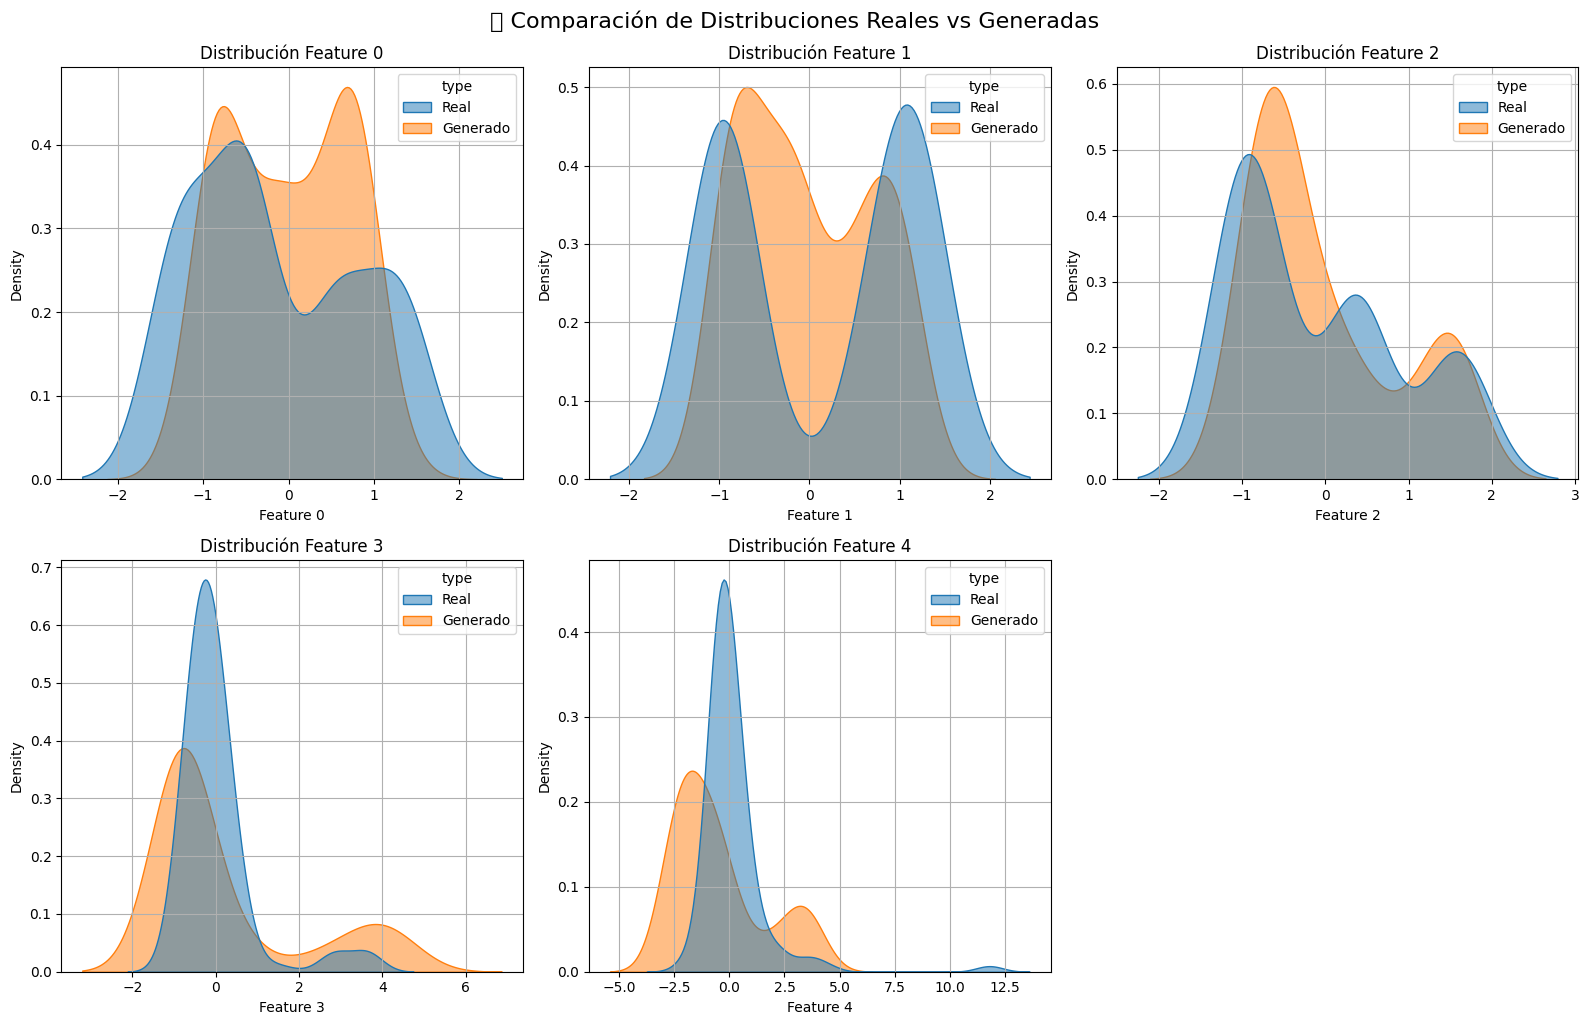

In [ ]:
import seaborn as sns
import pandas as pd

# ======= Comparar distribuciones reales vs generadas =======

# Número de muestras para comparar
n_samples = 100

# Real
real_samples = X_test[:n_samples].numpy()

# Generadas
z = torch.randn(n_samples, n_qubits)
generated_samples = G(z).detach().numpy()

# Crear DataFrame para fácil manipulación con seaborn
df_real = pd.DataFrame(real_samples, columns=[f"Feature {i}" for i in range(n_qubits)])
df_real["type"] = "Real"

df_fake = pd.DataFrame(generated_samples, columns=[f"Feature {i}" for i in range(n_qubits)])
df_fake["type"] = "Generado"

df_all = pd.concat([df_real, df_fake], ignore_index=True)

# ======= Gráfico por feature =======
plt.figure(figsize=(16, 10))
for i in range(n_qubits):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(data=df_all, x=f"Feature {i}", hue="type", fill=True, common_norm=False, alpha=0.5)
    plt.title(f"Distribución Feature {i}")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Comparación de Distribuciones Reales vs Generadas", fontsize=16, y=1.02)
plt.show()
